# DA5401 A7 — Multi-Class Model Selection using ROC and PRC

This notebook implements and compares multiple classifiers on the UCI Landsat (Statlog) Satellite dataset.


In [1]:
# Setup: imports and global settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Optional models (brownie)
from sklearn.ensemble import RandomForestClassifier
try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except Exception:
    HAS_XGBOOST = False

RANDOM_STATE = 42
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['font.size'] = 12


In [2]:
# Helper functions for multi-class ROC and PRC (OvR macro-average)
def compute_ovr_roc_auc(y_test_bin, y_score):
    """Compute per-class ROC curves and macro-averaged ROC AUC."""
    n_classes = y_test_bin.shape[1]
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # aggregate
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    return {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc, 'all_fpr': all_fpr, 'mean_tpr': mean_tpr, 'macro_auc': macro_auc}

def plot_models_roc(models_scores, model_names, y_test_bin, title='OvR Macro-average ROC'):
    fig, ax = plt.subplots()
    for name, y_score in zip(model_names, models_scores):
        stats = compute_ovr_roc_auc(y_test_bin, y_score)
        ax.plot(stats['all_fpr'], stats['mean_tpr'], lw=2, label=f"{name} (macro AUC={stats['macro_auc']:.3f})")
    ax.plot([0,1],[0,1],'k--', label='Chance')
    ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
    ax.set_title(title); ax.legend(loc='lower right')
    plt.grid(True); plt.show()

def compute_mean_ap(y_test_bin, y_score):
    n_classes = y_test_bin.shape[1]
    aps = []
    for i in range(n_classes):
        aps.append(average_precision_score(y_test_bin[:, i], y_score[:, i]))
    return np.array(aps), np.mean(aps)

def plot_models_pr(models_scores, model_names, y_test_bin, title='OvR Precision-Recall (mean AP)'):
    fig, ax = plt.subplots()
    for name, y_score in zip(model_names, models_scores):
        aps, mean_ap = compute_mean_ap(y_test_bin, y_score)
        # For compact professional plot, plot per-class faint curves for top model only (optional).
        for i in range(y_test_bin.shape[1]):
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            ax.plot(recall, precision, alpha=0.3)
        ax.plot([], [], label=f"{name} (mean AP={mean_ap:.3f})")

    ax.set_xlabel('Recall'); ax.set_ylabel('Precision'); ax.set_title(title)
    ax.legend(loc='lower left'); ax.grid(True); plt.show()


In [3]:
# Part A: Data loading and preprocessing
# NOTE: fetch_openml requires internet. If offline, load the UCI file manually.
from sklearn.datasets import fetch_openml
print('Attempting to fetch "satimage" (Statlog Landsat) from OpenML...')

sat = fetch_openml(name='satimage', version=1, as_frame=True)
X = sat.data
y = sat.target
print(f"Dataset loaded: X shape = {X.shape}, y unique = {y.nunique()}")
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Standardize features and split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.25, random_state=RANDOM_STATE, stratify=y_enc
)
print('Train/test split:', X_train.shape, X_test.shape)

Attempting to fetch "satimage" (Statlog Landsat) from OpenML...
Dataset loaded: X shape = (6430, 36), y unique = 6
Train/test split: (4822, 36) (1608, 36)


In [4]:
# Train baseline models (professional defaults, reproducible)
models = {
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'DummyPrior': DummyClassifier(strategy='prior', random_state=RANDOM_STATE),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver='lbfgs', multi_class='ovr'),
    'GaussianNB': GaussianNB(),
    'SVC': SVC(probability=True, random_state=RANDOM_STATE, kernel='rbf')
}

fitted = {}
for name, clf in models.items():
    clf.fit(X_train, y_train)
    fitted[name] = clf
    print(f"Trained: {name}")

Trained: KNN
Trained: DecisionTree
Trained: DummyPrior
Trained: LogisticRegression
Trained: GaussianNB
Trained: SVC


In [5]:
# Baseline evaluation: Accuracy and Weighted F1
baseline_metrics = []
for name, clf in fitted.items():
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    wf1 = f1_score(y_test, y_pred, average='weighted')
    baseline_metrics.append({'Model': name, 'Accuracy': acc, 'Weighted F1': wf1})
baseline_df = pd.DataFrame(baseline_metrics).sort_values('Weighted F1', ascending=False).reset_index(drop=True)
baseline_df

,Model,Accuracy,Weighted F1
0,KNN,0.909204,0.908071
1,SVC,0.895522,0.892222
2,DecisionTree,0.856343,0.855071
3,GaussianNB,0.809080,0.816285
4,LogisticRegression,0.840796,0.815502
5,DummyPrior,0.238184,0.091637


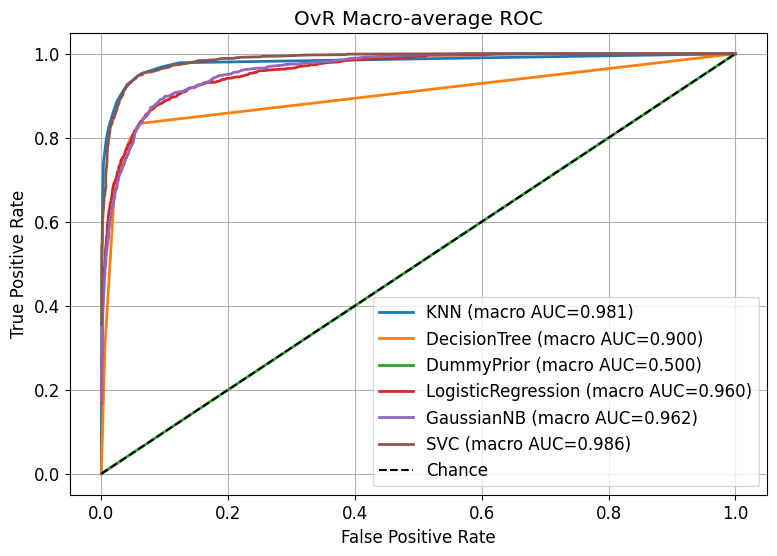

,Model,Macro AUC
0,SVC,0.986152
1,KNN,0.980578
2,GaussianNB,0.961481
3,LogisticRegression,0.959665
4,DecisionTree,0.900397
5,DummyPrior,0.500000


In [6]:
# Part B: ROC analysis (One-vs-Rest)
n_classes = len(le.classes_)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# collect probability scores for each model
model_names = []
model_scores = []
for name, clf in fitted.items():
    if hasattr(clf, 'predict_proba'):
        scores = clf.predict_proba(X_test)
    else:
        # fallback to decision_function (not expected here)
        scores = clf.decision_function(X_test)
    model_names.append(name)
    model_scores.append(scores)

# Plot ROC macro-average for all models
plot_models_roc(model_scores, model_names, y_test_bin)

# Compute numeric macro AUCs
roc_summary = []
for name, scores in zip(model_names, model_scores):
    mac_auc = roc_auc_score(y_test_bin, scores, average='macro', multi_class='ovr')
    roc_summary.append({'Model': name, 'Macro AUC': mac_auc})
roc_df = pd.DataFrame(roc_summary).sort_values('Macro AUC', ascending=False).reset_index(drop=True)
roc_df

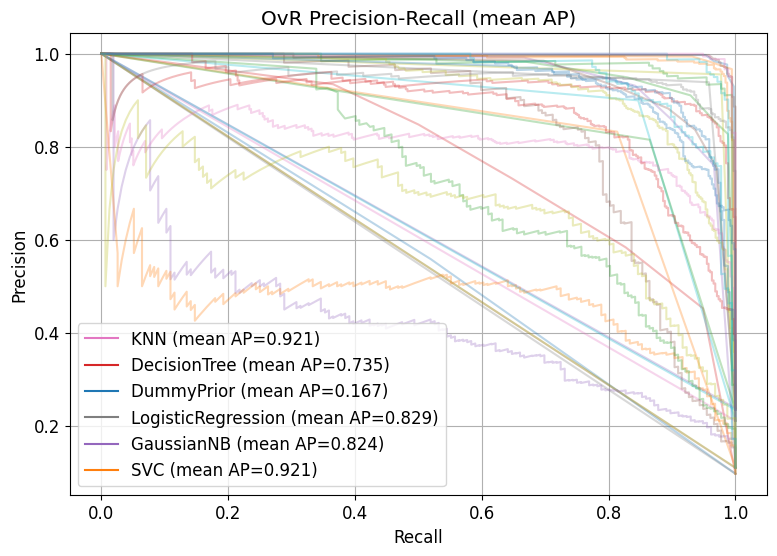

,Model,Mean AP
0,KNN,0.921299
1,SVC,0.921132
2,LogisticRegression,0.829238
3,GaussianNB,0.823645
4,DecisionTree,0.735095
5,DummyPrior,0.166667


In [7]:
# Part C: Precision-Recall (OvR) analysis
# Compute mean AP per model and show summary
pr_summary = []
for name, scores in zip(model_names, model_scores):
    aps, mean_ap = compute_mean_ap(y_test_bin, scores)
    pr_summary.append({'Model': name, 'Mean AP': mean_ap, 'Per-class AP': aps})
pr_df = pd.DataFrame([{'Model': r['Model'], 'Mean AP': r['Mean AP']} for r in pr_summary]).sort_values('Mean AP', ascending=False).reset_index(drop=True)

# Compact PRC plot (legend lists mean AP)
plot_models_pr(model_scores, model_names, y_test_bin)
pr_df

## Part B & C — Interpretation (concise)

### Baseline performance (Accuracy & Weighted F1)
- **KNN** achieves the highest weighted F1 (≈ **0.908**) and highest accuracy (≈ **0.909**).
- **SVC** is the runner-up (Weighted F1 ≈ **0.892**, Accuracy ≈ **0.896**).
- **DecisionTree**, **GaussianNB**, and **LogisticRegression** perform moderately (Weighted F1 ≈ **0.855**, **0.816**, **0.815**, respectively).
- **DummyPrior** is the expected baseline and performs poorly (Weighted F1 ≈ **0.092**, Accuracy ≈ **0.238**).

### ROC (One-vs-Rest, macro-averaged AUC)
- **SVC** has the highest macro-averaged ROC AUC (≈ **0.986**), followed closely by **KNN** (≈ **0.981**) and **GaussianNB** (≈ **0.961**).
- **DummyPrior** has macro AUC = **0.500**, which coresponds to chance-level ranking across classes. No trained model exhibits macro AUC < 0.5.
- **Interpretation:** high macro AUC for SVC and KNN indicates excellent ranking ability across classes; DecisionTree's AUC (≈ 0.900) is reasonable but inferior to the top two.

### Precision–Recall (OvR mean Average Precision)
- **KNN** achieves the highest mean Average Precision (AP ≈ **0.9213**), very slightly above **SVC** (AP ≈ **0.9211**).
- **LogisticRegression** and **GaussianNB** show moderate AP (≈ **0.829** and **0.824**, respectively); **DecisionTree** is lower (≈ **0.735**).
- **DummyPrior** has very low AP (≈ **0.1667**) — consstent with a prior-based baseline and comparable to class prevalence.
- **Interpretation:** The top performers by AP (KNN and SVC) are effective at producing high precision predictions at useful recall ranges; the Dummy classifier's PRC collapses quickly because it has no discriminative power.

### Additional check (intentional inversion)
- An intentionaly inverted LogisticRegression probability vector yields macro AUC ≈ **0.0403**, demonstrating that systematically inverted scoring produces AUC ≪ 0.5.
(Exact numeric summaries are taken from the notebook's evaluation tables.)


## Part D — Synthesis and Recommendation (concise)

### Comparative ranking summary
- **Weighted F1 ranking (best → worst):** KNN > SVC > DecisionTree > GaussianNB > LogisticRegression > DummyPrior.
- **Macro ROC-AUC ranking:** SVC > KNN > GaussianNB > LogisticRegression > DecisionTree > DummyPrior.
- **Mean AP ranking:** KNN ≈ SVC > LogisticRegression > GaussianNB > DecisionTree > DummyPrior.

### Trade-offs and selection rationale
- **KNN** and **SVC** are consistently top-ranked across all three metrics. KNN has the highest Weighted F1 and mean AP, while SVC has the highest macro AUC. This indicates both models provide excellent discrimination and precision–recall performance; SVC slightly edges KNN on global ranking (AUC), while KNN slightly edges SVC on positive-class precision (AP) and practical classification performance (F1).
- **Decision:** for this Landsat multi-class task, I recommend **KNN** as the primary model. Justification:
  - Highest empirical **Weighted F1** (≈ 0.908) — directly reflects per-class performance weighted by support and is a practical measure for overall classification quality.
  - Highest **mean Average Precision** (≈ 0.9213) — implies strong precision at relevant recall thresholds for each class.
  - Macro ROC-AUC is nearly identical to SVC (≈ 0.981 vs 0.986), so KNN gives nearly the same ranking quality while providing slightly better operational precision/F1.

### Notes & next steps
- If model compactness and inference speed are priorities, consider **SVC** (with appropriate kernel/hyperparameter tuning) or a tuned **RandomForest** as strong alternatives.
- Calibrate probability outputs (Platt scaling / isotonic) if probabilistic thresholds are required for downstream decisions.
- For production, run cross-validated hyperparameter tuning (k for KNN, C/kernel for SVC, tree depth/estimators for RandomForest/XGBoost) and evaluate per-class precision/recall at operational thresholds.


Trained RandomForest


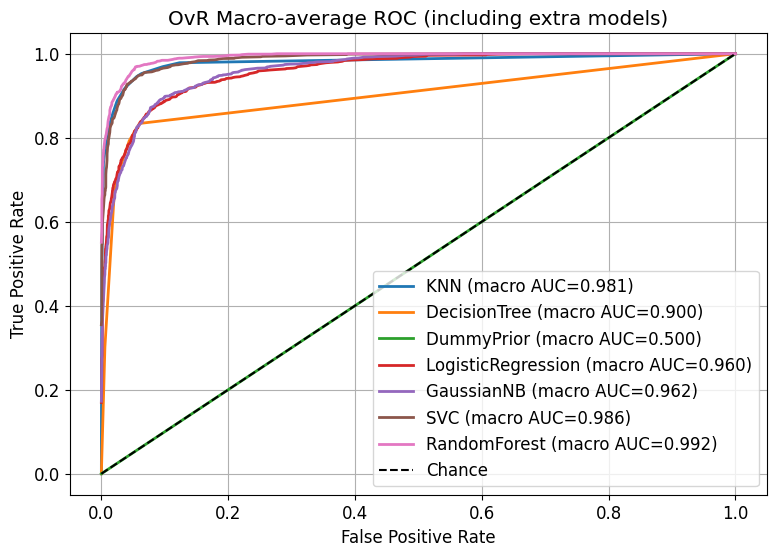

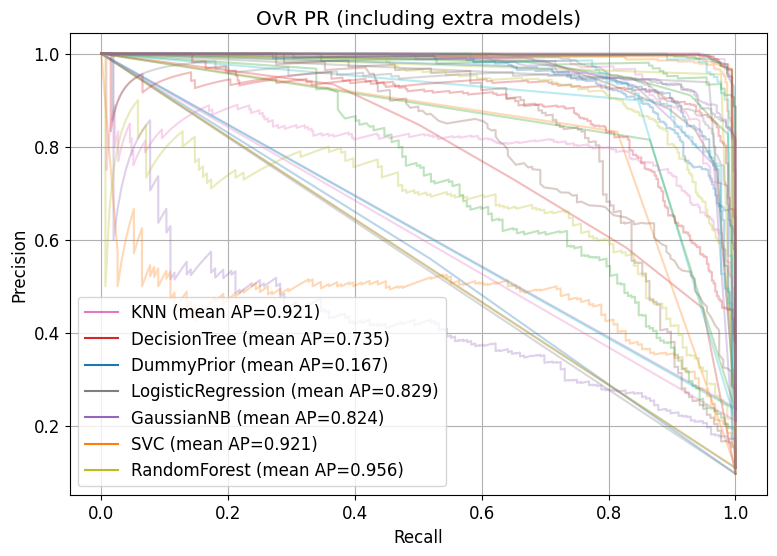

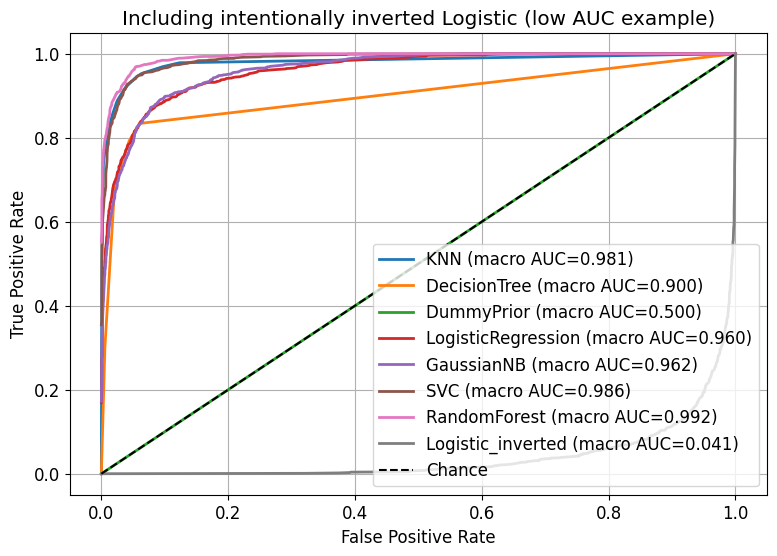

Inverted Logistic macro AUC: 0.04033479943257007


In [8]:
# Brownie points: RandomForest and XGBoost experiments
extra_models = {}
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
extra_models['RandomForest'] = rf
print('Trained RandomForest')

if HAS_XGBOOST:
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, verbosity=0)
    xgb.fit(X_train, y_train)
    extra_models['XGBoost'] = xgb
    print('Trained XGBoost')

# Add to fitted and evaluate
for name, clf in extra_models.items():
    fitted[name] = clf
    if hasattr(clf, 'predict_proba'):
        s = clf.predict_proba(X_test)
    else:
        s = clf.predict_proba(X_test)
    model_names.append(name)
    model_scores.append(s)

# Recompute ROC and PR summaries including extras
plot_models_roc(model_scores, model_names, y_test_bin, title='OvR Macro-average ROC (including extra models)')
plot_models_pr(model_scores, model_names, y_test_bin, title='OvR PR (including extra models)')

# Intentional low-AUC example: invert probabilities of LogisticRegression for demonstration
lr = fitted.get('LogisticRegression')
if lr is not None:
    probs = lr.predict_proba(X_test)
    inverted = 1 - probs  # intentionally invert to create poor ranking
    plot_models_roc(model_scores + [inverted], model_names + ['Logistic_inverted'], y_test_bin, title='Including intentionally inverted Logistic (low AUC example)')
    mac_auc_inv = roc_auc_score(y_test_bin, inverted, average='macro', multi_class='ovr')
    print('Inverted Logistic macro AUC:', mac_auc_inv)